# Parcial 1

La empresa esta interesada en crear grupos de casas basados en el precio, tamaño, precio
por metro cuadrado, número de habitaciones y baños, tipo de casa y ubicación.

Description of Columns:

* TYPE: Type of the house.

* PRICE: Price of the house.

* BEDS: Number of bedrooms.

* BATH: Number of bathrooms.

* PROPERTYSQFT: Square footage of the property.

* LATITUDE: Latitude coordinate of the house.

* LONGITUDE: Longitude coordinate of the house.

In [1]:
from google.colab import drive # conexión con drive
drive.mount('/content/drive')
import pandas as pd # Manejo de Data Frame
import numpy as np # Manejo matricial
import warnings # Omitir warnings
warnings.filterwarnings("ignore") # Ignorar warning (me estresan los warnings >:|)
# librerías para Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Librerías para clustering
from sklearn.cluster import (KMeans, AgglomerativeClustering)
from scipy.cluster.hierarchy import dendrogram,  linkage # Dendograma
# Score de silueta
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler # estandarizar variables.

Mounted at /content/drive


##1. Paso:
Se utilizará el código que encuentra en el buzón, donde se realiza un
preprocesamiento de los datos, simplemente cambie la ruta del archivo y ejecute.

In [12]:
datos = pd.read_csv("/content/drive/MyDrive/Aprendizaje no supervisador para el analisis de datos /Bases de datos/NY-House-Dataset.csv")
datos= datos[ datos["PRICE"]< 10**7]
datos=datos[datos["BEDS"] <20]
datos=datos[datos["BATH"] <20]
datos["TYPE"]= datos["TYPE"].replace({"Condop for sale": "Condo for sale",
                                      'Multi-family home for sale': "House for sale",
                                      # "Townhouse for sale":"House for sale",
                                      'Pending':np.nan, 'Contingent':np.nan})
categorias_drop = [ 'Land for sale', 'For sale', "House for sale",
                   'Foreclosure', 'Coming Soon',
                   'Mobile house for sale',"Townhouse for sale"]
datos["TYPE"] = datos["TYPE"].replace( categorias_drop, "Other")
datos = datos[~datos["TYPE"].isin(categorias_drop)]

##2. Paso:
Entendimiento de los datos: ¿los datos tienen registros faltantes? Elimínelos si los
tiene ¿cuántos datos quedan al final?


In [13]:
datos.isna().sum()

,0
BROKERTITLE,0
TYPE,327
PRICE,0
BEDS,0
BATH,0
PROPERTYSQFT,0
ADDRESS,0
STATE,0
MAIN_ADDRESS,0
ADMINISTRATIVE_AREA_LEVEL_2,0


In [14]:
num_datos = len(datos)
print(f"Número de datos: {num_datos}")

Número de datos: 4628


In [15]:
datos = datos.dropna()
datos.isna().sum()

,0
BROKERTITLE,0
TYPE,0
PRICE,0
BEDS,0
BATH,0
PROPERTYSQFT,0
ADDRESS,0
STATE,0
MAIN_ADDRESS,0
ADMINISTRATIVE_AREA_LEVEL_2,0


In [16]:
num_datos = len(datos)
print(f"Número de datos: {num_datos}")

Número de datos: 4301


Sí, la variable `TYPE` tenía 327 datos faltantes, por lo cual la base de datos tenía 4628 datos, una vez aplicada la limpieza quedaron 4301 datos.

## Paso 3:
Crear las variables:

a. Precio por cada metro cuadrado.

b. Número total de habitaciones y baños.

In [17]:
#Creación variable por metro cuadrado
datos["Precio_Metro_Cuadrado"]= datos["PRICE"]/datos["PROPERTYSQFT"]

In [18]:
#Creación variable Total de habitaciones y baños
datos["Total_Habitaciones_y_Baños"]= datos["BEDS"]+datos["BATH"]

Debe seleccionar las nuevas variables que creo y seleccionar TYPE, PRICE,
PROPERTYSQFT, LATITUD, LONGITUD.

In [37]:
data = datos[["TYPE", "PRICE", "PROPERTYSQFT", "LATITUDE", "LONGITUDE", "Precio_Metro_Cuadrado","Total_Habitaciones_y_Baños" ]]
data.head()

,TYPE,PRICE,PROPERTYSQFT,LATITUDE,LONGITUDE,Precio_Metro_Cuadrado,Total_Habitaciones_y_Baños
0,Condo for sale,315000,1400.000000,40.761255,-73.974483,225.000000,4.0
2,Other,260000,2015.000000,40.541805,-74.196109,129.032258,6.0
3,Condo for sale,69000,445.000000,40.761398,-73.974613,155.056180,4.0
5,Other,690000,4004.000000,40.674363,-73.958725,172.327672,7.0
6,Condo for sale,899500,2184.207862,40.809448,-73.946777,411.819779,4.0


## Paso 4:
De las variables seleccionadas, escoja solo 2 variables para realizar un análisis
descriptivo, debe incluir un gráfico que involucre las dos variables o dos gráficos por
cada variable. Debe realizar un análisis de las variables.


Variables a seleccionar: Precio_Metro_Cuadrado y TYPE

In [38]:
#Análisis descriptivo de la Variable Precio_Metro_Cuadrado
data["Precio_Metro_Cuadrado"].describe()

,Precio_Metro_Cuadrado
count,4301.000000
mean,652.794973
std,555.059488
min,1.141833
25%,320.000000
50%,480.265646
75%,781.059948
max,4685.792350


**Análisis descriptivo de la variable**:

- Hay 4391 datos.
- El precio medio por metro cuadrado es de 652.79 dolares.
- La desviación estandar es bastante alta, lo que quiere decir que hay alta variabilidad en los datos.
- El valor mínimo del precio por metro cuadrado es 1.14, lo que parece un valor atípico o un error en los datos.


In [39]:
#Análisis descriptivo de la variable TYPE
data["TYPE"].describe()

,TYPE
count,4301
unique,3
top,Other
freq,2015


**Análisis de la variable:**

- Hay 4301 datos y de estos solo hay tres tipos diferentes.
- El tipo de casa más frecuente es "Other" con 2015 observaciones, lo que representa aproximadamente el 46.8% del total de las observaciones.

In [40]:
#Gráfico comparativo de las variables
fig = px.box(data, x='TYPE', y='Precio_Metro_Cuadrado',
             title='Distribución del Precio por Metro Cuadrado por Tipo de Casa',
             labels={'TYPE':'Tipo de Casa', 'Precio_Metro_Cuadrado':'Precio por Metro Cuadrado'})
fig.show()


**Descripción de las Variables:**

**Condo for sale**:
- Condo for Sale es la propiedad que tiene mayr medieana en precio por metro cuadrado y es de 877.
- El rando cuartir para esta varibable es basnte disperso sobre todo hay una amplitud muy alta en el cuartir 3 lo que significa que hay una alta variabilidad en los datos.
- Existen varios datos atipícos lo que podrían significar que son casas de lujo.

**Other**:
- Su media es de 494.02.
- No tiene un rango intercuartil tan amplio como Condo for Sale.
- Hay una gran cantidad de datos atípidocs lo que sugiere la variabilidad de los precios.

**Co-op for sale:**
- Esta categoría muestra una mediana mucho más pequeña en comparación con las otras variables.
- Su rango intercuartil es el más pequeño, lo que indica la consistencia de los datos y los precios.


##Paso 5:

Realice una transformación de variables categóricas a dummy y estandarizar las
variables para aplicar los métodos de segmentación.


In [41]:
datos_numericos = pd.get_dummies(data,
                                 columns=['TYPE']) # Use column name as prefix

datos_numericos.head()

,PRICE,PROPERTYSQFT,LATITUDE,LONGITUDE,Precio_Metro_Cuadrado,Total_Habitaciones_y_Baños,TYPE_Co-op for sale,TYPE_Condo for sale,TYPE_Other
0,315000,1400.000000,40.761255,-73.974483,225.000000,4.0,False,True,False
2,260000,2015.000000,40.541805,-74.196109,129.032258,6.0,False,False,True
3,69000,445.000000,40.761398,-73.974613,155.056180,4.0,False,True,False
5,690000,4004.000000,40.674363,-73.958725,172.327672,7.0,False,False,True
6,899500,2184.207862,40.809448,-73.946777,411.819779,4.0,False,True,False


In [42]:
scaler = StandardScaler() # Función de estandarización
scaled_features = scaler.fit_transform(datos_numericos) #
pd.DataFrame(scaled_features, columns = datos_numericos.columns)

,PRICE,PROPERTYSQFT,LATITUDE,LONGITUDE,Precio_Metro_Cuadrado,Total_Habitaciones_y_Baños,TYPE_Co-op for sale,TYPE_Condo for sale,TYPE_Other
0,-0.660895,-0.329568,0.513882,-0.381258,-0.770809,-0.439757,-0.707600,2.013468,-0.938857
1,-0.698787,0.003329,-1.985800,-2.612202,-0.943725,0.172955,-0.707600,-0.496655,1.065125
2,-0.830374,-0.846504,0.515510,-0.382560,-0.896835,-0.439757,-0.707600,2.013468,-0.938857
3,-0.402543,1.079964,-0.475874,-0.222627,-0.865715,0.479311,-0.707600,-0.496655,1.065125
4,-0.258210,0.094920,1.062833,-0.102357,-0.434193,-0.439757,-0.707600,2.013468,-0.938857
...,...,...,...,...,...,...,...,...,...
4296,-0.465236,0.094920,0.663043,-0.193980,-0.682085,-1.052470,1.413228,-0.496655,-0.938857
4297,-0.709121,0.094920,0.186775,0.769640,-0.974110,-1.052470,1.413228,-0.496655,-0.938857
4298,0.000487,0.094920,0.338770,-0.672316,-0.124432,-1.052470,1.413228,-0.496655,-0.938857
4299,-0.465839,-0.732832,0.303331,0.642804,0.469145,-0.746113,-0.707600,2.013468,-0.938857


## Paso 6:

Aplique K-means y Clúster jerárquico, determine el número de clústeres con los
métodos propuestos en el curso (método del codo, puntaje de silueta y dendograma
para el caso de clúster jerárquico). Justifique cual es el número de clústeres para kmeans y Clúster jerárquico.


###K-Means

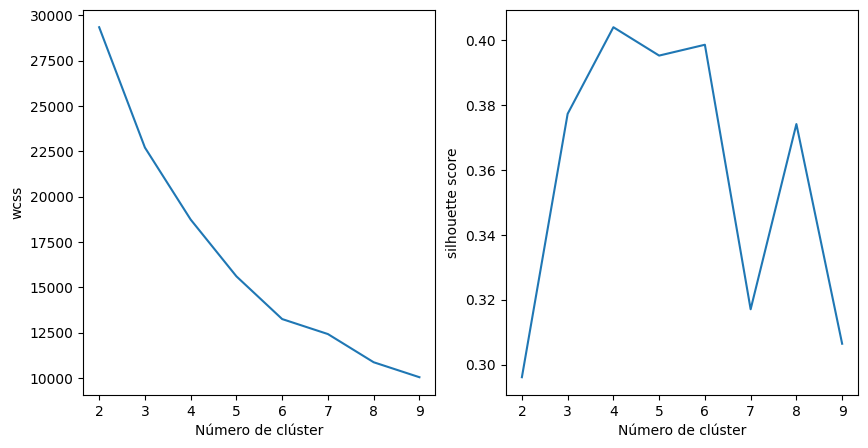

In [43]:
silueta_score=[]
wcss =[]
n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k)
  k_means.fit(scaled_features)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(scaled_features, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

In [68]:
k_means=KMeans(6, random_state=123  )
k_means.fit(scaled_features )
data["labels_k_means"]= k_means.labels_

**Análisis de los métodos:**

- **Método del Codo:** visualmente hay dos "Codos" uno en el clúster 4 y otro en el clúster 6, donde la curva del clúster 6 es más pronunciada que la del clúster 4.

- **Método de silueta**: El punto más alto que muestra el gráfico es en el clúster 4 y el segundo clúster más alto es el 6.

- Para el método K-Mean implementaria el clúster 6.

###Clúster Jerárquico:


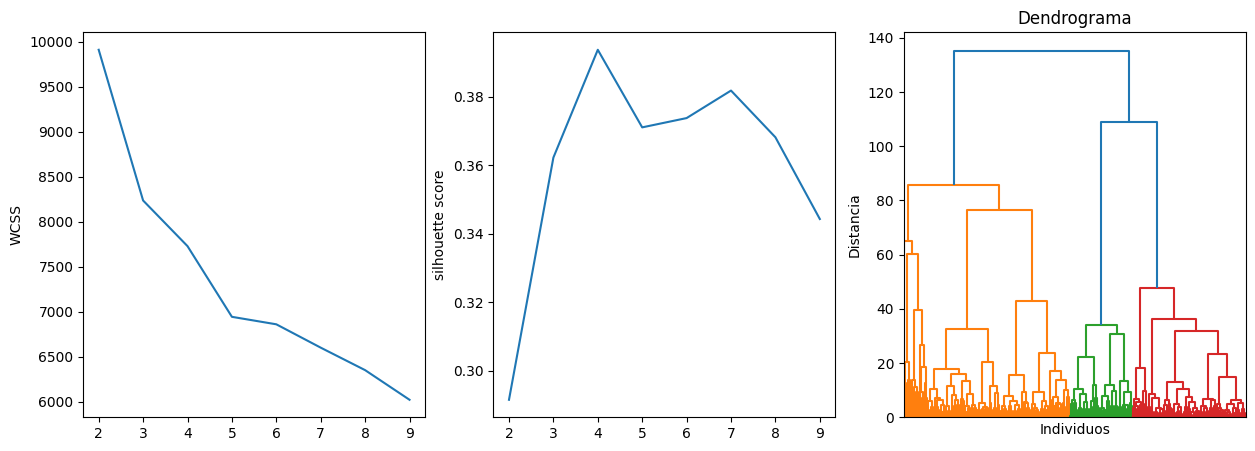

In [62]:
silueta =[]
wcss =[]
n_cluster=range(2,10)
for i in n_cluster:
  jerarquico = AgglomerativeClustering(i)
  jerarquico.fit(scaled_features)
  scaled_temp= pd.DataFrame(scaled_features)
  scaled_temp["labels"]=jerarquico.labels_
  centros= scaled_temp.groupby("labels").mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(scaled_features,centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  score = silhouette_score(scaled_features,jerarquico.labels_ )
  silueta.append(score)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot( (n_cluster), wcss  )
axes[0].set_ylabel("WCSS")
axes[1].plot( (n_cluster), silueta  )
axes[1].set_ylabel("silhouette score")

# visualización clustering jerarquico
dist_matrix = linkage(scaled_features, method='ward')
# Visualizar el dendrograma
dendrogram(dist_matrix,no_labels=True)
axes[2].set_title('Dendrograma')
axes[2].set_xlabel('Individuos')
axes[2].set_ylabel('Distancia')
plt.show()

In [73]:
hc=AgglomerativeClustering(6)
hc.fit(scaled_features )
data["labels_hc"]= hc.labels_

**Elección número de clústeres**

**Método del codo:** en este primer gráfico los números de clústeres sugeridos por son de 3 y 5 dados que es donde el codo es mucho más pronunciado.

**Método de silueta**: El punto que es significativamente más alto es el clúster 4.

**Dendrograma**: Al realizar un corte en el dendrogama el número de clústeres que mejor distribuye los datos es de 5.

- **En conclusión:** El número de clústeres a elegir es de 6 ya que es el más congruentes entre los métodos.


##Punto 7:

Seleccione un solo algoritmo (K-means o Clúster jerárquico), con el número de clústeres definido en dicho algoritmo. Realice gráficos, resúmenes estadísticos para cada clúster. De una descripción de cada clúster tanto para los clústeres con el
algoritmo seleccionado. Para crear la descripción debe incluir gráficos que involucren
la ubicación, TYPE y seleccione una variable adicional.

Algoritmo a elegir: K-Means.

Número de Clústeres: 6

,proportion
labels_k_means,
1,31.667054
0,26.621716
4,17.972565
3,17.530807
2,6.114857
5,0.093002


Text(0.5, 1.0, 'Clúster con K-means')

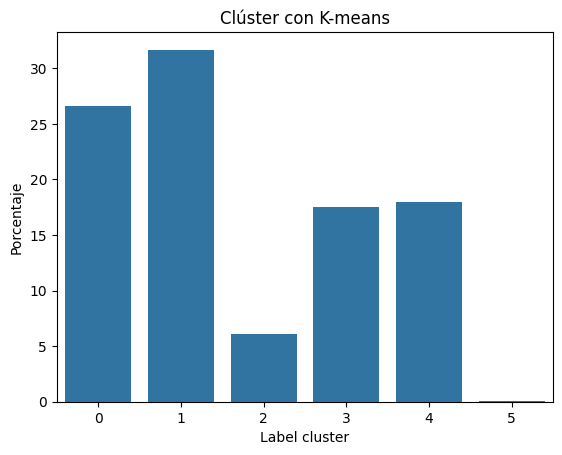

In [74]:
display(data['labels_k_means'].value_counts(normalize=True)*100)
sns.barplot( data['labels_k_means'].value_counts(normalize=True)*100 )
plt.xlabel("Label cluster")
plt.ylabel("Porcentaje")
plt.title("Clúster con K-means")

**Nota:** Los números son etiquetas y ahora nos corresponde a nosotros etiquetarlas

In [75]:
tabla1 = data.groupby('labels_k_means')["TYPE"].value_counts(normalize=True)
px.bar(tabla1.reset_index(), x='labels_k_means',y="proportion" , color="TYPE", barmode='group')

In [77]:
name_cluster= 'labels_k_means'
titulo = 'Clúster con k-means 6 clúster'
fig = px.box(data, color=name_cluster, y='PRICE',
             title=titulo)
fig.update_xaxes(title_text="Label cluster")
fig.update_yaxes(title_text="Price")

fig.show()

In [78]:
kmeans = KMeans(n_clusters=6,  random_state=123) # Definir el algoritmo
kmeans.fit(scaled_features)  # Entrenar el modelo
data["cluster"] = kmeans.labels_ # Obtener las etiquetas
data["cluster"] = data["cluster"].astype(str) # Convertir a categoria

fig = px.scatter_mapbox(data, lat="LATITUDE", lon="LONGITUDE", color="cluster")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

##Análisis de las Variables**:

**Clúster 0**:

- El clúster representa el 26.62% de los datos.
- El tipo de casa más común para ese clúster es de "Other" con una proporción de 1.
- Tiene una media de 0.98 millones de dolares para el precio.
- Estás casas estan es su mayoría en la costa de Nueva York, a los alrededores de Manhatan, Queens y Yorks

**Clúster 1**:
- El clúster representa el 31.66% de los datos
- El tipo de casa más común para este clúster es "Co-op for sale".
- Los precios en este clúster muestran una variabilidad moderada con la mediana más baja en comparación con otros clústeres, indicando propiedades de precios más accesibles dentro de su distribución.
- Predomina en la región central del mapa, con una alta concentración en Manhattan y Statten Island

**Clúster 2:**:
- Representa el 6.11% de los datos
- Este clúster presenta los tres tipo de vivienda casi en proporciones iguales,pero se ve que predominaun poco más la variable "Other".
- Este clúster es el que tiene a segunda mediana de alrededor de un precio de 5 millones y su rango intercuartil es bastante amplio y no presenta datos apiticos. Lo que quiere decir que hay una variabilidad constante en los datos.
- Su ubicación es mucho más centrada en el mapa con gran densidad en la zona de Queens y cerca a New york

**Clúster 3**

- Representa el 3	17.53%
- Las casa de este clúster son Condo por sale.
- Tiene una media bastante baja, y cuartil 3 es bastante más grande en comaparación con los demás, lo que quiere decir que el 75% de los precios estan al rededor de 1.35 millones de dolares
- Estas casa al ser de un precio tan alto se encuentran más cerca a la costa y al centro de Manhathan y Central Park.

**Clúster 4:**
- Se presenta el 17.97% de los datos
- La mediana en el precio es mucho más alta que el clúster 948.88 en su precio.
- Presenta varios datos atípicos lo que significa la variabilidad en los precios.
- El tipo de casa muestra una mezcla entre "Other"
- Su ubicación es mucho más centrada en en New York y Manthan en comparasión con los clústeres 0 y 1.

**Clúster 5:**
- Representan el 0.09% de los datos
- La casas de este clúster son "Other"
- El precio de las casas, su mediana se encuentra por encima de los demás clústeres con una mediana de 6.38. También su rango intercuartil es mucho más condensado lo que quiere decir que los precios no varian casi. Sus valores están entre los 5 y 7 millones.
- Estás casas estan es su mayoría en la costa de Nueva York, a los alrededores de Manhatan, Queens y Yorks

##Punto 8:
De una conclusión general sobre los resultados obtenidos que se relacione con la
problemática y mencione algún tipo de propuesta para un solo clúster del algoritmo
seleccionado.

- En conclusión las casa en Nueva York tienen a ser de precios muy elevandos.
- La mayoria de las viviendas son otras, lo que pueden ser de renta por aoplicación o lugares de paso para turistas.
- La ubicación de las casa más costosas se encuentras más cerca los lugares más emblematicos, turisticos y de la Zona fianaciera.
- La recomendación que le daría a la empreza es que potencie las otras casas del clúster 5 que son para los clientes de casa de lujo, saber porque les gusta comprar ahí.
- A las casas que estan más alejadas tratar de potenciarlas para que se vuelvas mucho más atracticas a los consumidores.
- También trataría de incentivar las casa del clúster 1 que son las que tienen un mayor porcentaje de participación, ya que son las casas más baratas y trataría de crear más insentivos con bajos intereses